#Code to calculate the slope of high gamma and phase-amplitude coupling in ECoG data

#####Torben Noto 2015
Matlab code for this is available elsewhere on the VoytekResearch Github

In [16]:
#importing modules
%config InlineBackend.figure_format = 'retina'
%pylab inline
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import os
import scipy.io
import scipy.signal
from scipy.signal import butter, filtfilt, hilbert
import scipy.fftpack

Populating the interactive namespace from numpy and matplotlib


In [17]:
#importing data
filename = 'emodat.mat'; #filename
filename = os.path.join('/Users/Torben/Desktop/Voytek_Things/', filename) #path to file
data = sp.io.loadmat(filename)
srate = 1000 # sampling rate
data = data['data'] # 84 channels of ECoG data
data = data[0, :] #one channel of ECoG data (can be between 1 and 84)
data =  squeeze(data); 

sw_size = 1000;

In [18]:
#filtering functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    #lowcut is the lower bound of the frequency that we want to isolate
    #hicut is the upper bound of the frequency that we want to isolate
    #fs is the sampling rate of our data
    nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

#This function applies Butterworth filter to data
def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, mydata)
    return y

In [19]:
#Applying filters on data to get theta and high gamma
lo_freq = [4,8];
hi_freq = [80, 125];

hi_band = butter_bandpass_filter(data, hi_freq[0], hi_freq[1], round(srate))
hi_band = abs(hilbert(hi_band))

lo_hi_band = butter_bandpass_filter(hi_band, lo_freq[0], lo_freq[1], round(srate));
lo_hi_band = angle(hilbert(lo_hi_band));

lo_band = butter_bandpass_filter(data, lo_freq[0], lo_freq[1], round(srate))
lo_band = angle(hilbert(lo_band));

In [20]:
#pad data to remove edge artifacts

newdat= list(chain(data[sw_size-1::-1],data,data[len(data):len(data)-sw_size-1:-1]))
newlo_hi= list(chain(lo_hi_band[sw_size-1::-1],lo_hi_band,lo_hi_band[len(lo_hi_band):len(lo_hi_band)-sw_size-1:-1]))
newlo= list(chain(lo_band[sw_size-1::-1],lo_band,lo_band[len(lo_band):len(lo_band)-sw_size-1:-1]))

new_lo_hi = list(np.array(newlo_hi) - np.array(newlo))

mPSD_dat = np.zeros((len(newdat)));
PAC_dat = np.zeros((len(newdat)));

In [21]:
#parameters to calculate slope of high gamma
mPSD_params = [80, 125];

# Number of samples in sliding window

# sample spacing
T = 1.0/srate;
x = np.linspace(0.0, sw_size*T, sw_size)

#frequencies of fft vals
xf = np.linspace(0.0, 1.0/(2.0*T), sw_size/2) 
xf = floor(xf);

#finding closest fx bin to lower fx boundary
bin0 = min(xf, key=lambda x:abs(x-mPSD_params[0])); 
bin0ind = find(xf == bin0);
bin0ind = min(bin0ind); #in case there are multiple bins for the same frequency after rounding

#finding closest fx bin to upper fx boundary
bin1 = min(xf, key=lambda x:abs(x-mPSD_params[1])); 
bin1ind = find(xf == bin1);
bin1ind = min(bin1ind); #in case there are multiple bins for the same frequency after rounding

In [28]:
#Calculate PSD and PAC over sliding window
#This takes a few minutes to run. Increase sw_size in the cell above to speed it up.

for i in xrange(len(newdat)-sw_size):
    this_window = newdat[i:i+sw_size] * np.hanning(sw_size);
    #multiplying by a hanning window to reduce spectral leakage in the fft
    #calculating fft
    yf = scipy.fftpack.fft(this_window) #fft
    yf = log10(abs(yf));
    
    #finding amplitudes of mPSD frequencies
    amp0 = yf[bin0ind];
    amp1 = yf[bin1ind];

    #solving for slope of fft at slope bounds
    a = np.array([[bin0,1], [bin1,1]]); #xvals
    b = np.array([amp0,amp1]); #yvals
    m = np.linalg.solve(a, b);
    mPSD_dat[i] = m[0]; #m[0] is slope m[1] is y intercept

    #calculating PAC
    temp = new_lo_hi[i:i+sw_size];
    PAC_dat[i] = abs(sum(exp(dot(1j, temp)))) / len(temp); #Calculating circular mean of phase/amp difference to get PAC


In [27]:
print len(newdat)-sw_size
print i


1477035
1475036


In [48]:
#remove padding 
mPSD_dat = mPSD_dat[sw_size:];
mPSD_dat = mPSD_dat[:sw_size];

PAC_dat = PAC_dat[sw_size:];
PAC_dat = PAC_dat[:sw_size];

Correlation between PAC and slope of high gamma


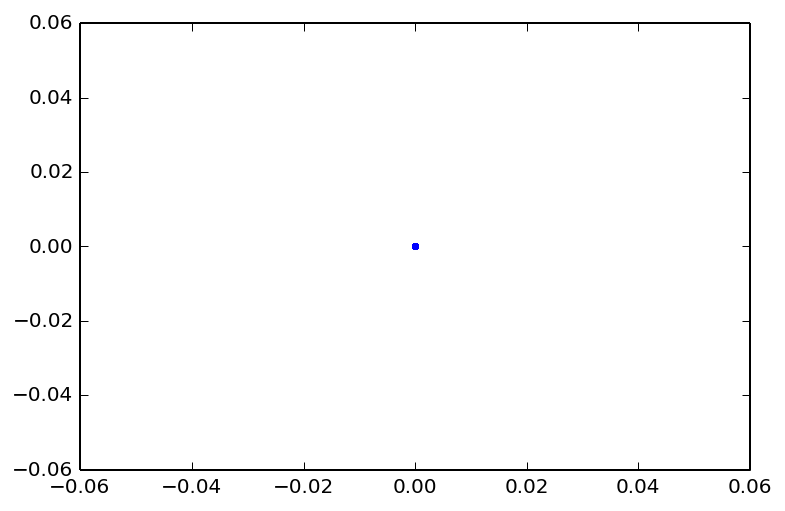

In [49]:
c = np.correlate(PAC_dat,mPSD_dat) #find correlation between PAC and dHG
print 'Correlation between PAC and slope of high gamma'
plot(mPSD_dat,PAC_dat,'.')